In [1]:
import FTIR_functions as FTIR
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c as C
from scipy import interpolate as spinter, optimize as spopt

import ipywidgets as widgets
from IPython.display import display

plt.rcParams.update({"image.cmap": 'Greys_r', 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True,})

In [2]:
############# STEP 0 : OPEN IMAGE FILE ##################

source = "ir" # Source nickname as it appears in the file name. "blue" "green" "red" "FBH800" "ir" "FBH1600" "big"
run = 6
file_type = ".tif"
ref = 0 # Referance image. This image will be processed into the spectrum

fringes, beamA, beamB, background = FTIR.import_standard_photo(source, run, file_type)

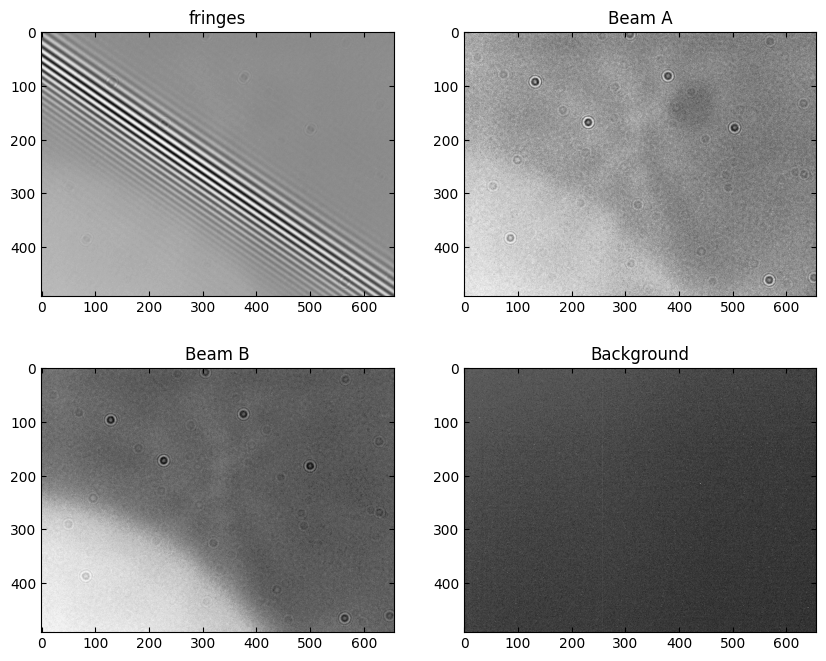

In [3]:
fig, axs = plt.subplots(2, 2, figsize= (10,8))
axs = axs.flatten()

im = axs[0].imshow(fringes[:,:,ref])
axs[0].set(title= "fringes")

axs[1].imshow(beamA)
axs[1].set(title= "Beam A")

axs[2].imshow(beamB)
axs[2].set(title= "Beam B")

axs[3].imshow(background)
axs[3].set(title= "Background")

plt.show()

In [4]:
########### STEP 1: BACKGROUND SUBTRACT ############

fringes_subtracted, no_fringes = FTIR.bg_subtract(fringes, beamA, beamB, background, dead_pixels= 0)

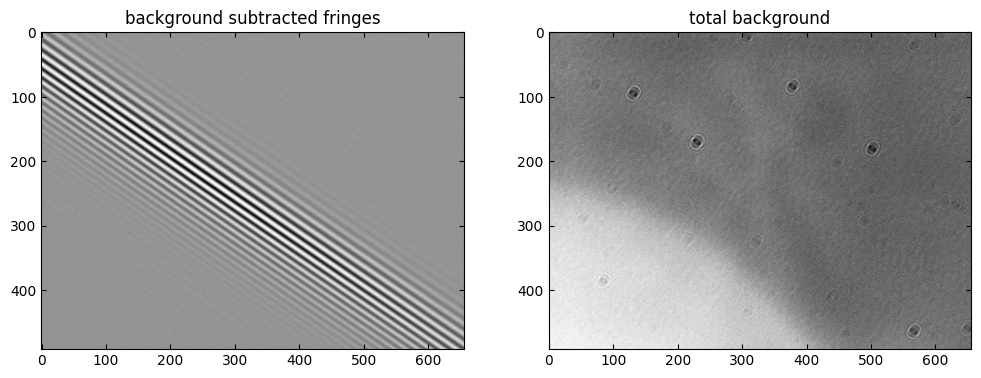

In [5]:
fig, axs = plt.subplots(1, 2, figsize= (12,6))

im = axs[0].imshow(fringes_subtracted[:,:,ref])
axs[0].set(title= "background subtracted fringes")

im = axs[1].imshow(no_fringes[:,:,ref])
axs[1].set(title= "total background")

plt.show()

In [6]:
########### STEP 2: MAKE 1D #############

theta = 5 #arcminutes
camera = "xeva" # camera nickname. "manta" "xeva" "purple" "pyro"

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

def sinminutes(arcminutes):
    return np.sin(np.deg2rad(arcminutes/60))

def bounding_box(x_bounds, y_bounds, line_points, line_gradient): # returns the intersection points
    x_bounds = np.sort(x_bounds)
    y_bounds = np.sort(y_bounds)
    line_points = np.array(line_points) #should be (x, y)

    if line_gradient == 0:
        return x_bounds, np.repeat(line_points[1], 2), [True, True, False, False]
    #else:

    x_intercepts = 1/line_gradient *(y_bounds -line_points[1]) +line_points[0] #find the points where the line intercepts the y limits (floor and ceiling)
    is_x_intercept_within_bounds = np.logical_and(x_bounds[0] <= x_intercepts, x_intercepts <= x_bounds[1])
    y_intercepts = line_gradient *(x_bounds -line_points[0]) +line_points[1] #find the points where the line intercepts the x limits (left and right sides)
    is_y_intercept_within_bounds = np.logical_and(y_bounds[0] <= y_intercepts, y_intercepts <= y_bounds[1])

    x_intercepts = np.concatenate((x_intercepts[is_x_intercept_within_bounds], x_bounds[is_y_intercept_within_bounds])) # [[intercept], [intercept], [left], [right],
    y_intercepts = np.concatenate((y_bounds[is_x_intercept_within_bounds], y_intercepts[is_y_intercept_within_bounds])) #  [floor], [ceiling], [intercept], [intercept]]

    collisions = np.concatenate([is_x_intercept_within_bounds, is_y_intercept_within_bounds])
    return x_intercepts, y_intercepts, collisions # [floor, ceiling, left, right]

rows, columns = fringes_subtracted[:,:,ref].shape

cam_length = columns*pixel_pitch*1e-3 # in mm
cam_height = rows*pixel_pitch*1e-3 # in mm
x = np.linspace(0, cam_length, columns, endpoint= False)
y = np.linspace(0, cam_height, rows, endpoint= False)

FT2d = np.fft.fftshift(np.fft.fft2(fringes_subtracted[:,:,ref], norm= "forward"))

k_x = np.fft.fftshift(np.fft.fftfreq(columns, pixel_pitch*1e-3)) #in mm^-1
k_y = np.fft.fftshift(np.fft.fftfreq(rows, pixel_pitch*1e-3))

dk_x = 1 /(rows*pixel_pitch*1e-3)
dk_y = 1 /(columns*pixel_pitch*1e-3)

freq_x = C*k_x /(2*sinminutes(theta)) *1e3 #convert wavenumber in mm^-1 (as it appears on the camera) to frequency in Hz (of source)
freq_y = C*k_y /(2*sinminutes(theta)) *1e3
dfreq_x = C*dk_x /(2*sinminutes(theta)) *1e3
dfreq_y = C*dk_y /(2*sinminutes(theta)) *1e3


In [7]:
def slice_2d(interferogram2d, alpha):
    rows, columns = interferogram2d.shape

    FT2d = np.fft.fftshift(np.fft.fft2(interferogram2d))
    k_x = np.fft.fftshift(np.fft.fftfreq(columns)) #in pixels^-1
    k_y = np.fft.fftshift(np.fft.fftfreq(rows))

    _, _, collisions = bounding_box((k_x[0], k_x[-1]), (k_y[0], k_y[-1]), (0,0), np.tan(alpha))

    if collisions[0] and collisions[1]: #floor to ceiling line
        line_x = np.zeros_like(k_y) if alpha == 0 else k_y /np.tan(alpha)
        line_y = k_y
    elif collisions[2] and collisions[3]: #left to right line
        line_x = k_x
        line_y = k_x *np.tan(alpha)
    else:
        collisions_lookup = np.array(["floor","ceiling","left","right"])
        print(type(alpha), type(collisions_lookup[collisions][0]), type(collisions_lookup[collisions][1]))
        raise ValueError("This line with angle {0:.2f} reaches from {1:} to {2:}.".format(alpha, *collisions_lookup[collisions]))

    linear_interpolation = spinter.RegularGridInterpolator((k_y, k_x), FT2d, bounds_error= False, fill_value= 0) # When trying to interpolate a value on the edge of the bounds, RegularGridInterpolator will throw an error for the upper bound but not the lower bound.

    FT1d = linear_interpolation(list(zip(line_y, line_x)))
    FT1d = np.fft.fftshift(FT1d)
    interferogram1d = np.fft.ifft(FT1d)

    return interferogram1d, FT1d

def find_alpha(interferogram2d):
    def to_minimise(alpha):
        _, FT1d = slice_2d(interferogram2d, alpha)
        return -np.sum(np.abs(FT1d))
    
    result = spopt.minimize_scalar(to_minimise, bounds= (-np.pi/2, np.pi/2), method= "bounded")

    return result.x


def recenter(interferogram):
    length = len(interferogram)
    max_index = np.argmax(interferogram)
    tau = length//2 -max_index

    FT = np.fft.fft(interferogram)
    freq = np.fft.fftfreq(length)
    FT *= np.exp(-2j*np.pi*freq*tau)

    interferogram = np.fft.ifft(FT)
    return interferogram


C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


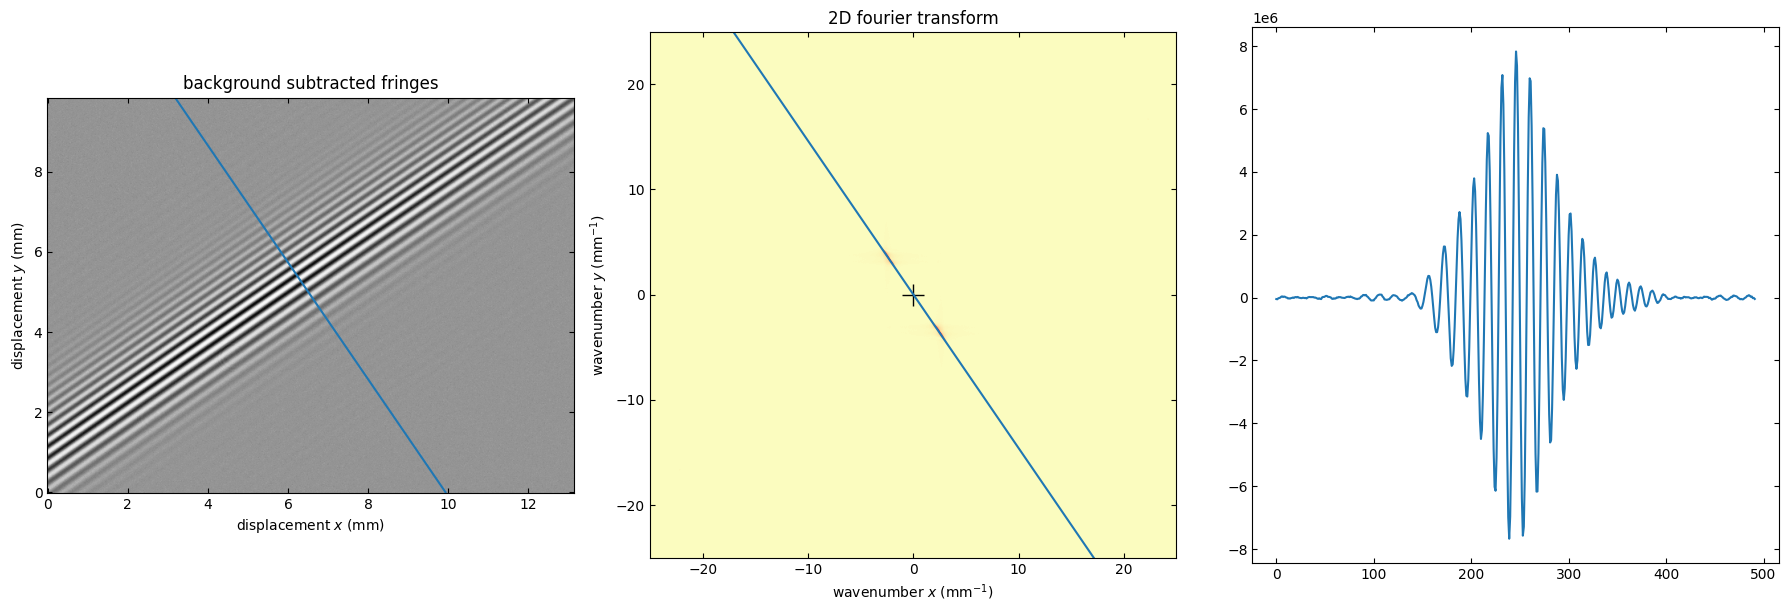

In [9]:
cam_extent=  (-pixel_pitch*1e-3/2, cam_length +pixel_pitch*1e-3/2,
              -pixel_pitch*1e-3/2, cam_height +pixel_pitch*1e-3/2)

k_extent= (k_x[0] -dk_x/2, k_x[-1] +dk_x/2,
           k_y[0] -dk_y/2, k_y[-1] +dk_y/2)

alpha = -0.97

fig, axs = plt.subplots(1, 3, figsize= (18,6))

x_intercepts, y_intercepts, _ = bounding_box((0, cam_length), (0, cam_height), (cam_length/2, cam_height/2), np.tan(alpha))

axs[0].imshow(fringes_subtracted[:,:,ref], origin= "lower", extent= cam_extent)
axs[0].plot(x_intercepts, y_intercepts)
axs[0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

k_x_intercepts, k_y_intercepts, _ = bounding_box((k_x[0], k_x[-1]), (k_y[0], k_y[-1]), (0,0), np.tan(alpha))

axs[1].imshow(np.abs(FT2d), origin= "lower", extent= k_extent, cmap= "magma_r")
axs[1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
axs[1].plot(k_x_intercepts, k_y_intercepts)
axs[1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

fringes_1d, _ = slice_2d(fringes_subtracted[:,:,ref], alpha)
fringes_1d = recenter(fringes_1d)

axs[2].plot(fringes_1d)

plt.tight_layout()
plt.show()

In [10]:
find_alpha(fringes_subtracted[:,:,ref])

-0.9697238598936745

In [14]:
# Define the function to plot
def plot_function(alpha):
    fig, axs = plt.subplots(1, 3, figsize= (18,6))

    x_intercepts, y_intercepts, _ = bounding_box((0, cam_length), (0, cam_height), (cam_length/2, cam_height/2), np.tan(alpha))

    axs[0].imshow(fringes_subtracted[:,:,ref], origin= "lower", extent= cam_extent)
    axs[0].plot(x_intercepts, y_intercepts)
    axs[0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

    k_x_intercepts, k_y_intercepts, _ = bounding_box((k_x[0], k_x[-1]), (k_y[0], k_y[-1]), (0,0), np.tan(alpha))

    axs[1].imshow(np.abs(FT2d), origin= "lower", extent= k_extent, cmap= "magma_r")
    axs[1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
    axs[1].plot(k_x_intercepts, k_y_intercepts)
    axs[1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

    fringes_1d, _ = slice_2d(fringes_subtracted[:,:,ref], alpha)
    fringes_1d = recenter(fringes_1d)

    axs[2].plot(fringes_1d)

    plt.show()

# Create interactive variable
decimal_places = 2
alpha_slider = widgets.BoundedFloatText(value=0.0, min=np.round(-np.pi/2, decimal_places), max=np.round(np.pi/2, decimal_places), step= 10**-decimal_places, description='alpha (rad):', disabled= False)

# Create auto button
auto_button = widgets.Button(description='Auto', button_style='info')

# Define auto function
def auto_values(button):
    alpha_slider.value = find_alpha(fringes_subtracted[:,:,ref])  # Set the slider value to a predefined value

# Connect the button to the auto function
auto_button.on_click(auto_values)

# Display the interactive plot with slider and button
interactive_plot = widgets.interact(plot_function, alpha=alpha_slider)
display(auto_button)


interactive(children=(BoundedFloatText(value=0.0, description='alpha (rad):', max=1.57, min=-1.57, step=0.01),…

Button(button_style='info', description='Auto', style=ButtonStyle())